# Final Project Submission
---

## Info

* Student name: **Barto Molina**
* Student pace: **part time**
* Scheduled project review date/time: **10/15/2019 5:00 PM (EST)**
* Instructor name: **Victor Geislinger**
* Blog post URL: [...](https://medium.com/@bartomolina/...)

## The Project

The goal of the project is to find the best 5 zipcodes across the US to invest in and model and project the median price for those zipcodes in the coming years. We're going to select these top zipcodes based on the distance to our workplace and the ROI from the past years.

We obtained the data from the [Zillow Research website](https://www.zillow.com/research/data/), which uses the ZHVI (Zillow Home Value Index) - A smoothed, seasonally adjusted measure of the median estimated home value across a given region and housing type. We've used the ZHVI for All Homes (SFR, Condo/Co-op) dataset.

## Imports

We'll import the required libraries that will be used throughout the rest of the project:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import googlemaps
import folium
import json
import random

In [2]:
# we use dotenv to use Google API key
# use .env.example as a reference
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_KEY = os.getenv("GOOGLE_KEY")
gmaps = googlemaps.Client(key=GOOGLE_KEY)

## 0. Parameters
---

We will use this parameters to perform different calculations:

- **arrival_time**: Date used for the distance calculations when using the Google API.
- **target_location**: Destination used to calculate the distance from the different zipcodes when using the Google API.
- **max_commuting_time**: Maximum commuting time in minutes used to calculate the top 5 zipcodes.

In [3]:
# Monday Nov. 4th. 9 AM
arrival_time = datetime.datetime(2019, 11, 4, 9, 0)
target_location = "United Nations Secretariat Building, East 42nd Street, New York, NY"
max_commuting_time = 45

## 1. Load the dataset / Data cleansing
---

In [4]:
df = pd.read_csv('zillow_data.csv', dtype={'RegionName' : str })
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,167200.0,167400.0,167400.0,...,1051500,1029200,1014300,1008700,991500,973400,965800,967100,967800,965400
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,148200.0,148900.0,149400.0,...,314500,314700,314600,312900,311000,309700,308900,308400,307000,305700
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,350900.0,351700.0,352300.0,...,1375700,1370100,1369000,1362500,1358300,1369700,1394900,1403200,1405400,1412700
3,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,160800.0,162700.0,164200.0,...,367100,365900,364800,362800,360300,357600,354200,348900,343800,341500
4,61616,10002,New York,NY,New York-Newark-Jersey City,New York County,5,NaN,NaN,NaN,...,966100,954500,949600,943700,928400,913300,901400,892700,891200,889900


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770 entries, 0 to 4769
Columns: 289 entries, RegionID to 2019-09
dtypes: float64(237), int64(47), object(5)
memory usage: 10.5+ MB


As our zipcode selection is going to be based on the distance to Midtown Manhattan, I'm going to limit the results to the states of **New York**, **New Jersey** and **Conneticut**:

In [6]:
# create a new dataframe with the house price information for the states of NY, NJ and CT
df_NY = df.loc[df['State'].isin(['NY', 'NJ', 'CT'])].copy()
df_NY.reset_index(drop=True, inplace=True)

In [7]:
df_NY.shape

(466, 289)

Looking at the first few rows, We've noticed some null values. As our dataset is large enough, We can probably remove the columns / rows that contain null values. First, I'm going to check which columns contain null values and how many:

In [8]:
for col in df_NY:
    if df_NY[col].isnull().sum():
        print(f"{col} - {df_NY[col].isnull().sum()}")

Metro - 1
1996-04 - 42
1996-05 - 42
1996-06 - 42
1996-07 - 42
1996-08 - 42
1996-09 - 42
1996-10 - 42
1996-11 - 42
1996-12 - 42
1997-01 - 42
1997-02 - 42
1997-03 - 42
1997-04 - 42
1997-05 - 42
1997-06 - 42
1997-07 - 42
1997-08 - 42
1997-09 - 42
1997-10 - 42
1997-11 - 42
1997-12 - 42
1998-01 - 42
1998-02 - 42
1998-03 - 42
1998-04 - 42
1998-05 - 42
1998-06 - 42
1998-07 - 42
1998-08 - 42
1998-09 - 42
1998-10 - 42
1998-11 - 42
1998-12 - 42
1999-01 - 42
1999-02 - 42
1999-03 - 42
1999-04 - 42
1999-05 - 42
1999-06 - 42
1999-07 - 42
1999-08 - 42
1999-09 - 42
1999-10 - 42
1999-11 - 42
1999-12 - 42
2000-01 - 42
2000-02 - 42
2000-03 - 42
2000-04 - 42
2000-05 - 42
2000-06 - 42
2000-07 - 42
2000-08 - 42
2000-09 - 42
2000-10 - 42
2000-11 - 42
2000-12 - 42
2001-01 - 42
2001-02 - 42
2001-03 - 42
2001-04 - 42
2001-05 - 42
2001-06 - 42
2001-07 - 42
2001-08 - 42
2001-09 - 42
2001-10 - 42
2001-11 - 42
2001-12 - 42
2002-01 - 42
2002-02 - 42
2002-03 - 42
2002-04 - 42
2002-05 - 42
2002-06 - 42
2002-07 - 42
20

There's missing information for the first few years for almost 10% of the zipcodes. As we have data for enough years, I'm going to keep only the information for the past **10 years**:

In [9]:
df_NY.drop(df_NY.iloc[:, 7:168], axis=1, inplace=True) 

I will remove the zipcodes that contain null values:

In [10]:
df_NY.dropna(inplace=True)

Now that we have removed all the null values from our dataset, let's look at the different counties:

In [11]:
df_NY['CountyName'].value_counts().head(10)

New York County     39
Bergen County       33
Kings County        30
Queens County       30
Monmouth County     28
Middlesex County    23
Nassau County       19
Morris County       17
New Haven County    16
Suffolk County      15
Name: CountyName, dtype: int64

## 2. Selecting the top 5 zipcodes
---

In order to select the top 5 zipcodes, we're going to calculate the distance to the workplace and the ROI for the last 10 years:

### First, let's calculate the distance from each zipcode to the target location

We'll use the [Google API](https://github.com/googlemaps/google-maps-services-python) to calculate the distance from each zipcode to the target location. In order to calculate the distance, we'll look at the walking and the transit distance and we'll select the fastest route. Then, we'll store the distance in minutes in a new column **Distance**:

In [12]:
df_NY['Distance'] = np.nan

for i, zipcode in df_NY.iterrows():
    # calculate the transit distance from the zipcode to our target destination
    directions_transit = gmaps.directions(zipcode['RegionName'], target_location, mode='transit', arrival_time=arrival_time)
    # calculate the walking distance from the zipcode to our target destination
    directions_walking = gmaps.directions(zipcode['RegionName'], target_location, mode='walking', arrival_time=arrival_time)
    if directions_transit or directions_walking:
        distance_transit = np.NaN if not directions_transit else directions_transit[0]['legs'][0]['duration']['value']
        distance_walking = np.NaN if not directions_walking else directions_walking[0]['legs'][0]['duration']['value']
        # we set the distance as the shortest walking / transit distance
        df_NY.at[i, 'Distance'] = np.nanmin([distance_walking, distance_transit]) / 60

We'll remove the zipcodes for which we couldn't calculate the route (if any) and limit the results to the maximum commuting time defined in the parameters:

In [15]:
df_NY.dropna(subset=['Distance'], inplace=True)
df_NY_by_dist = df_NY.loc[df_NY['Distance'] <= max_commuting_time].copy()
print(len(df_NY))
print(len(df_NY_by_dist))

439
53


Now, we'll generate a json with the geometries for each of the zipcodes contained in our result dataset and plot a map with the distance of each of the zipcodes to the workspace:

In [46]:
# prepare json with the selected zipcodes geometries

ny_geo_path = 'ny_new_york_zip_codes_geo.min.json'
nj_geo_path = 'nj_new_jersey_zip_codes_geo.min.json'
ct_geo_path = 'ct_connecticut_zip_codes_geo.min.json'
with open(ny_geo_path) as ny_geo_file, open(nj_geo_path) as nj_geo_file, open(ct_geo_path) as ct_geo_file:
    NY_zip = json.load(ny_geo_file)
    NJ_zip = json.load(nj_geo_file)
    CT_zip = json.load(ct_geo_file)
    
all_features = NY_zip['features'] + NJ_zip['features'] + CT_zip['features']

tristate_data = {}
tristate_data['type'] = 'FeatureCollection'
tristate_data['features'] = list()

for zipcode in all_features:
    code = zipcode['properties']['ZCTA5CE10']
    if code in df_NY_by_dist['RegionName'].values:
        zipcode['properties']['ZCTA5CE10'] = code
        distance = df_NY_by_dist.loc[df_NY_by_dist['RegionName'] == code, 'Distance'].values[0].round(2)
        zipcode['properties']['Zipcode'] = code
        zipcode['properties']['Distance'] = f'{distance}m'
        tristate_data['features'].append(zipcode)

tristate_json_data = json.dumps(tristate_data)

In [60]:
# print folium map helper function

def print_map(df, columns, legend, tooltip):
    m = folium.Map(location=[40.75, -73.97], zoom_start=12)

    choropleth = folium.Choropleth(highlight=True,
        geo_data=tristate_json_data,
        name='choropleth',
        data=df,
        columns=columns,
        key_on='feature.properties.Zipcode',
        fill_color='OrRd',               
        fill_opacity=0.7,
        line_opacity=0.4,
        legend_name=legend
    ).add_to(m)

    folium.LayerControl().add_to(m)

    # add tooltip to see the zipcode
    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(tooltip, labels=True)
    )

    return m

In [48]:
print_map(['RegionName', 'Distance'], 'Distance to target location', ['Zipcode', 'Distance'])

There is a total of **53** zipcodes within the range of **45** minutes from work.

### Calculate the 10 yr. ROI for each of the zipcodes

We're going to calculate the 10 yr. ROI for each of the zipcodes by creating a new column in our dataframe:

In [49]:
df_NY_by_dist['ROI'] = ((df_NY_by_dist['2019-09'] - df_NY_by_dist['2009-09']) / df_NY_by_dist['2009-09'] * 100).round()

In [50]:
df_NY_by_dist.head()
df_NY.loc[df_NY['RegionName'] == '10010']

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2009-09,2009-10,2009-11,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,Distance
85,61624,10010,New York,NY,New York-Newark-Jersey City,New York County,631,1134500.0,1113300.0,1098400.0,...,1692500,1692200,1689600,1667000,1642000,1628600,1623100,1617900,1612900,12.8


In [51]:
# adding the ROI to the zipcode json variable used in the map
for feature in tristate_data['features']:
    code = feature['properties']['ZCTA5CE10']
    ROI = int(df_NY_by_dist.loc[df_NY_by_dist['RegionName'] == code, 'ROI'].values[0])
    feature['properties']['ROI'] = f"{ROI}%"
    
tristate_json_data = json.dumps(tristate_data)

In [52]:
print_map(['RegionName', 'ROI'], 'ROI', ['Zipcode', 'ROI'])

### Calculate Distance - ROI index

Based on the previous analysis. We're going assign each zipcode a DRI (Distance - ROI index). We're going to weight both parameters and calculate this index as follows:

In [55]:
df_NY_by_dist['DRI'] = (1 / df_NY_by_dist['Distance']) + (df_NY_by_dist['ROI'] / 100)

In [56]:
df_NY_Top_5 = df_NY_by_dist.sort_values(by='DRI', ascending=False).head().copy()
df_NY_Top_5

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2009-09,2009-10,2009-11,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,Distance,ROI,DRI
12,62017,11206,New York,NY,New York-Newark-Jersey City,Kings County,26,384100.0,381800.0,382500.0,...,742600,740600,739500,740300,740600,742500,742600,37.233333,93.0,0.956858
94,62033,11222,New York,NY,New York-Newark-Jersey City,Kings County,748,497200.0,500100.0,504700.0,...,951100,952200,956400,959200,956700,951900,947200,35.950000,91.0,0.937816
53,62004,11101,New York,NY,New York-Newark-Jersey City,Queens County,270,597100.0,592000.0,588100.0,...,1119900,1129100,1130600,1129700,1128100,1122800,1118200,26.100000,87.0,0.908314
118,62058,11249,New York,NY,New York-Newark-Jersey City,Kings County,1121,602600.0,594300.0,588900.0,...,1085700,1077100,1049000,1047300,1097000,1142000,1129100,40.466667,87.0,0.894712
27,62022,11211,New York,NY,New York-Newark-Jersey City,Kings County,75,531000.0,527200.0,525700.0,...,958800,959600,961300,964000,968300,970100,967100,40.833333,82.0,0.844490


In [79]:
# adding the DRI to the zipcode json variable used in the map
for feature in tristate_data['features']:
    code = feature['properties']['ZCTA5CE10']
    DRI = round(df_NY_by_dist.loc[df_NY_by_dist['RegionName'] == code, 'DRI'].values[0], 2)
    feature['properties']['DRI'] = f"{DRI}"
    
tristate_json_data = json.dumps(tristate_data)

In [243]:
m = print_map(df_NY_Top_5, ['RegionName', 'DRI'], 'Distance - ROI index', ['Zipcode', 'Distance', 'ROI', 'DRI'])

from folium.features import DivIcon
# m = folium.Map([40.75, -73.97], zoom_start=13)

def add_marker(location, zipcode):
    folium.map.Marker(
        location,
        icon=DivIcon(
            icon_size=(39,0),
            icon_anchor=(0,0),
            html=f"<div style='font-size:10pt;background-color:white;border:1px solid black'>{zipcode}</div>",
            )
        ).add_to(m)

# add markers to the map
add_marker([40.75, -73.94], 11101)
add_marker([40.733, -73.95], 11222)
add_marker([40.715, -73.965], 11249)
add_marker([40.717, -73.95], 11211)
add_marker([40.704, -73.942], 11206)
m

So, given our calculations, the best zipcodes to buy a property in NY would be:

- **Brooklyn**:
  - 11206: 37m - 93%
  - 11222: 36m - 91%
  - 11211: 41m - 82%
  - 11249: 40m - 87%


- **Astoria**:
  - 11101: 26m - 87%

## 3. Top 5 zipcodes - Time Series Analysis
---

After selecting the top 5 zipcodes based on our previous requirements, we're going to analyze and model them in order to determine which one will be the best to invest in:

In [223]:
# helper melt_data function
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.set_index('time')

In [226]:
# remove columns and melt data
df_top5_ts = df_NY_Top_5.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'Distance', 'ROI', 'DRI'], axis=1)
df_top5_ts = melt_data(df_top5_ts)

In [227]:
# create a dictionary with a dataframe for each zipcode
df_ts_zipcode = {}
for zipcode in df_top5_ts.RegionName.unique():
    df_code = df_top5_ts[df_top5_ts['RegionName'] == zipcode]
    df_ts_zipcode[zipcode] = df_code

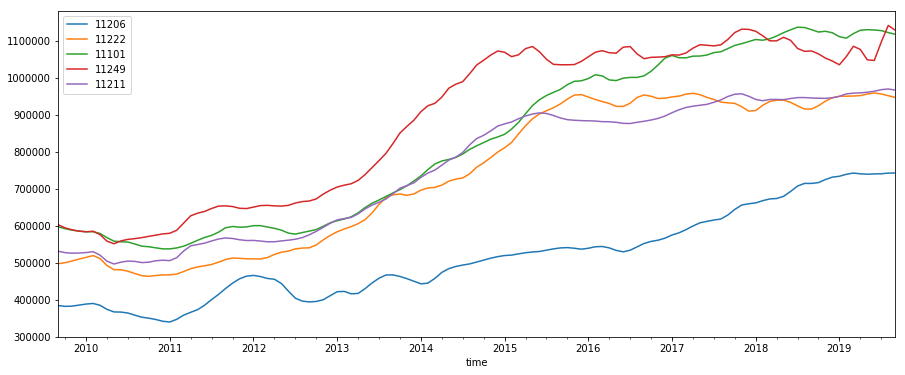

In [228]:
for zipcode in df_ts_zipcode:
    df_ts_zipcode[zipcode]['value'].plot(label=zipcode,figsize=(15,6))
    plt.legend()

We can see that the prices follow an upwarding trend, but doesn't present any seasonality. We're going to proceed to calculate the monthly and yearly returns in order to eliminate the effect of this trend and obtain a more **stationary** time series to build our model.

### Calculate monthly and annual return

Now, let's calculate the annual (%) return for each of the zipcodes:

In [239]:
df_ts_zipcode_pct_change_monthly = {}
df_ts_zipcode_pct_change_annual = {}

for zipcode in df_ts_zipcode:
    # calculate monthly return
    df_ts_zipcode_pct_change_monthly[zipcode] = df_ts_zipcode[zipcode]['value'].pct_change()
    # calculate annual return (downsampling)
    tmp_pct_change = df_ts_zipcode[zipcode]['value'].pct_change()
    df_ts_zipcode_pct_change_annual[zipcode] = tmp_pct_change.resample('Y').sum()

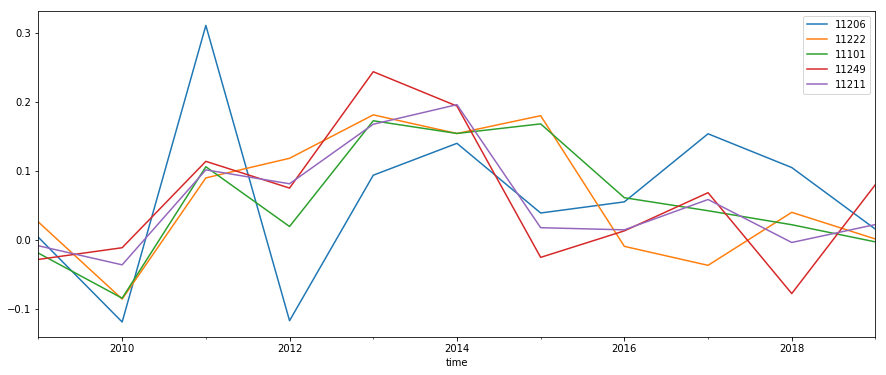

In [240]:
for zipcode in df_ts_zipcode_pct_change:
    df_ts_zipcode_pct_change_annual[zipcode].plot(label=zipcode,figsize=(15,6))
    plt.legend()

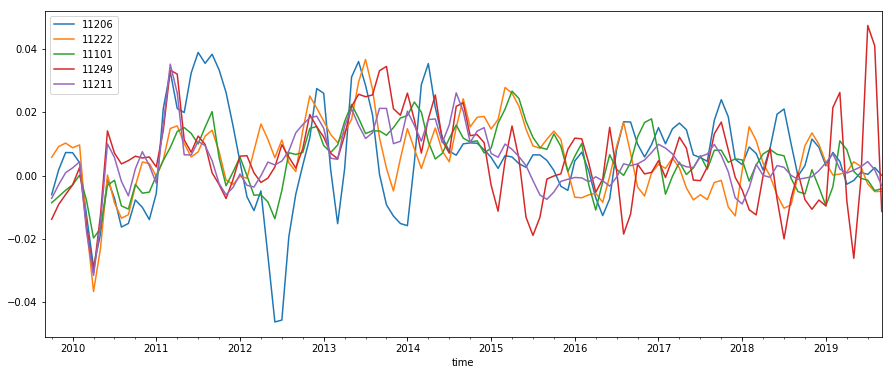

In [255]:
for zipcode in df_ts_zipcode_pct_change:
    df_ts_zipcode_pct_change_monthly[zipcode].plot(label=zipcode,figsize=(15,6))
    plt.legend()

The annual returns give us a better idea of the % changes and variance for each of the zipcodes: we can see a slightly different pattern for the 11206 zipcode while the rest have a similar performance throughout the years.

Another thing we need to take into account before workion on our model is to check for the normality. Let's do it for both the annual and the monthly return values:

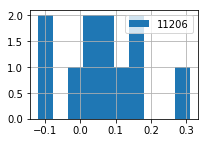

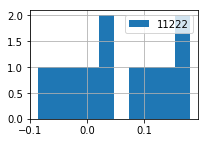

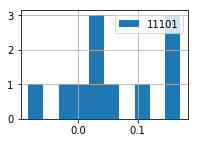

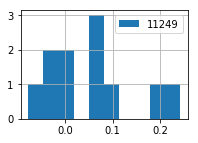

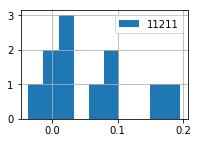

In [252]:
# annual return normality check
for zipcode in df_ts_zipcode_pct_change:
    df_ts_zipcode_pct_change_annual[zipcode].hist(label=zipcode,figsize=(3,2))
    plt.legend()
    plt.show()

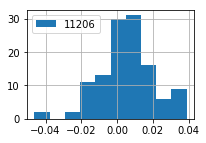

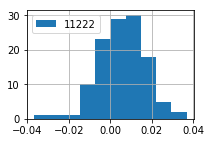

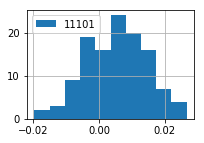

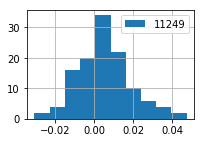

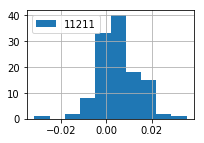

In [253]:
# monthly return normality check
for zipcode in df_ts_zipcode_pct_change:
    df_ts_zipcode_pct_change_monthly[zipcode].hist(label=zipcode,figsize=(3,2))
    plt.legend()
    plt.show()

Although the distributions doesn't exactly look Gausian / Normal for neither the annual or the monthly returns, the monthly ones are much closer to a normal distribution, and this is the data that we'll use in our model.

### Check for stationarity

## Step 3: EDA and Visualization

In [ ]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

## Step 5: ARIMA Modeling

## Step 6: Interpreting Results

## Future work

- Better calculate distance (currently just an average point in the zipcode)
- Better function weighting roi vs. distance